In [42]:
from collections import Counter

import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from pydot import graph_from_dot_data
import io
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

import random
random.seed(246810)
np.random.seed(246810)

eps = 1e-5  # a small number

In [ ]:
"""
To prepare the starter code, copy this file over to decision_tree_starter.py
and go through and handle all the inline TODOs.
"""

class DecisionTree:

    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.labels = np.array([])

    @staticmethod
    def entropy(y):
        class_counts = np.bincount(y)
        probs = class_counts / len(y)
        entropy = -1 * np.sum(probs * np.log2(probs + eps))
        return entropy

    @staticmethod
    def information_gain(X, y, thresh):
        """X is a single feature, not the design matrix"""
        left_indices = (X < thresh)
        right_indices = np.logical_not(left_indices)

        y_l = y[left_indices]
        y_r = y[right_indices]

        if len(y_l) == 0 or len(y_r) == 0:
            return 0

        H_S = DecisionTree.entropy(y)
        H_Sl = DecisionTree.entropy(y_l)
        H_Sr = DecisionTree.entropy(y_r)

        H_after = ((len(y_l) * H_Sl) + (len(y_r) * H_Sr)) / (len(y_l) + len(y_r))

        information_gain = H_S - H_after
        return information_gain

    def split(self, X, y, feature_idx, thresh):

        left_indices = (X[:, feature_idx] < thresh)
        right_indices = np.logical_not(left_indices)


        left_X, left_y = X[left_indices], y[left_indices]
        right_X, right_y = X[right_indices], y[right_indices]

        return left_X, left_y, right_X, right_y
            
    def find_best_split(self, X, y):
        best_gain = -float("inf")
        best_feature_index = None
        best_thresh = None

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for thresh in thresholds:
                gain =  self.information_gain(X[:, feature_index], y, thresh)
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_thresh = thresh
        
        return best_gain, best_feature_index, best_thresh
    
    def fit(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            self.pred = np.unique(y)[0]
            return
        if depth >= self.max_depth:
            self.pred = np.bincount(y).argmax(0)
            return
        gain, feature_index, thresh = self.find_best_split(X, y)
        
        if gain == 0:
            self.pred = np.bincount(y).argmax()
            return
        
        left_X, left_y, right_X, right_y = self.split(X, y, feature_index, thresh)

        self.labels = y
        self.data = X
        self.split_idx = feature_index
        self.thresh = thresh

        self.left = DecisionTree(max_depth=self.max_depth, feature_labels=self.features)
        self.right = DecisionTree(max_depth=self.max_depth, feature_labels=self.features)
        self.left.fit(left_X, left_y, depth=depth + 1)
        self.right.fit(right_X, right_y, depth=depth + 1)

    def predict(self, X):
        predictions = np.array([self._predict_single(x) for x in X])
        return predictions
        
    def _predict_single(self, x):
        if self.pred is not None:
            return self.pred
        if x[self.split_idx] < self.thresh:
            return self.left._predict_single(x)
        else:
            return self.right._predict_single(x)
    
    def predict_single_print(self, x):
        if self.pred is not None:
            print(f"Arrive at leaf node. Predict {self.pred}")
            return self.pred
        if x[self.split_idx] < self.thresh:
            print(f"{self.features[self.split_idx]} < {self.thresh}")
            return self.left.predict_single_print(x)
        else:
            print(f"{self.features[self.split_idx]} >= {self.thresh}")
            return self.right.predict_single_print(x) 

class BaggedTrees(BaseEstimator, ClassifierMixin):

    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        self.trees = []
        for i in range(self.n):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            boostrap_X, boostrap_y = X[indices], y[indices]
            tree = self.decision_trees[i]
            tree.fit(boostrap_X, boostrap_y)
            self.trees.append(tree)
        
    def predict(self, X):
        preds = np.zeros((self.n, X.shape[0]))
        for i in range(self.n):
            tree = self.trees[i]
            preds[i, :] = tree.predict(X)
        maj_preds, trash = scipy.stats.mode(preds, axis=0)
        return maj_preds.flatten()


class RandomForest(BaggedTrees):

    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        params['max_features'] = m
        self.m = m
        super().__init__(params=params, n=n)

def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for col in range(data.shape[1]):
            # -1 = missing data, useless for finding mode
            # find mode and then fill in vals with -1
            nonmissing_data = data[data[:, col] != -1, col]            
            mode = stats.mode(nonmissing_data)[0]
            data[data[:, col] == -1, col] = mode

    return data, onehot_features

def generate_submission(testing_data, predictions, dataset="titanic"):
    assert dataset in ["titanic", "spam"], f"dataset should be either 'titanic' or 'spam'"
    # This code below will generate the predictions.csv file.
    if isinstance(predictions, np.ndarray):
        predictions = predictions.astype(int)
    else:
        predictions = np.array(predictions, dtype=int)
    assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
    df = pd.DataFrame({'Category': predictions})
    df.index += 1  # Ensures that the index starts at 1.
    df.to_csv(f'predictions_{dataset}.csv', index_label='Id')

In [ ]:
if __name__ == "__main__":
    dataset = "titanic"
    # dataset = "spam"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 200

    if dataset == "titanic":
        # Load titanic data
        path_train = '/Users/bryanhwang/Downloads/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = '/Users/bryanhwang/Downloads/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0]
        y = np.array(y[labeled_idx], dtype=float).astype(int)
        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, 1:]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = '/Users/bryanhwang/Downloads/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features", features)
    print("Train/test size", X.shape, Z.shape)

    # Decision Tree
    print("\n\nDecision Tree")
    dt = DecisionTree(max_depth=4, feature_labels=features)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=189)
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_val)
    print(accuracy_score(predictions, y_val))

    # Random Forest
    print("\n\nRandom Forest")
    rf = RandomForest(params, n=N, m=np.int_(np.sqrt(X.shape[1])))
    rf.fit(X, y)
    evaluate(rf)

    # Generate Test Predictions
    print("\n\nGenerate Test Predictions")
    pred = rf.predict(Z)
    generate_submission(Z, pred, dataset)



Part (b): preprocessing the titanic dataset
Features [b'pclass', b'sex', b'age', b'sibsp', b'parch', b'ticket', b'fare', b'cabin', b'embarked', b'male', b'female', b'S', b'C', b'Q']
Train/test size (999, 14) (310, 14)


Decision Tree
0.8


Random Forest
Cross validation [0.785     0.82      0.76      0.835     0.8040201]
First splits [(b'male', 51), (b'pclass', 35), (b'female', 33), (b'fare', 21), (b'age', 14), (b'parch', 14), (b'sibsp', 11), (b'S', 10), (b'C', 8), (b'Q', 3)]


Generate Test Predictions


In [36]:
# 4.4
# Titanic dataset
def fourfourhelper(dataset):
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 200

    if dataset == "titanic":
        # Load titanic data
        path_train = '/Users/bryanhwang/Downloads/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = '/Users/bryanhwang/Downloads/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0]
        y = np.array(y[labeled_idx], dtype=float).astype(int)
        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, 1:]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = '/Users/bryanhwang/Downloads/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)


    dt = DecisionTree(max_depth=4, feature_labels=features)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=189)
    dt.fit(X_train, y_train)
    val_predictions = dt.predict(X_val)
    print(f"{dataset} decision tree validation accuracy: {accuracy_score(val_predictions, y_val)}")
    train_predictions = dt.predict(X_train)
    print(f"{dataset} decision tree training accuracy: {accuracy_score(train_predictions, y_train)}")

    # 4.5 code
    rand_idx = np.random.randint(X_train.shape[0])
    rand_datapoint = X_train[rand_idx]
    print(f"{dataset} random point path")
    dt.predict_single_print(rand_datapoint)

    rf = RandomForest(params, n=N, m=np.int_(np.sqrt(X.shape[1])))
    rf.fit(X_train, y_train)
    val_predictions = rf.predict(X_val)
    print(f"{dataset} random forest validation accuracy: {accuracy_score(val_predictions, y_val)}")
    train_predictions = rf.predict(X_train)
    print(f"{dataset} random forest training accuracy: {accuracy_score(train_predictions, y_train)}")

In [37]:
fourfourhelper("titanic")
fourfourhelper("spam")

titanic decision tree validation accuracy: 0.8
titanic decision tree training accuracy: 0.8222778473091364
titanic random point path
b'male' < 1.0
b'pclass' < 3.0
b'fare' >= 26.25
b'age' >= 4.0
Arrive at leaf node. Predict 1
titanic random forest validation accuracy: 0.755
titanic random forest training accuracy: 0.8335419274092616
spam decision tree validation accuracy: 0.8135265700483092
spam decision tree training accuracy: 0.7955039883973894
spam random point path
exclamation >= 1.0
meter < 1.0
ampersand < 1.0
money < 1.0
Arrive at leaf node. Predict 1
spam random forest validation accuracy: 0.8386473429951691
spam random forest training accuracy: 0.8138747884940778


In [38]:
depths = [i for i in range(1, 41)]
val_accuracies = []

for depth in depths:
    dt = DecisionTree(max_depth=depth, feature_labels=features)
    dt.fit(X_train, y_train)
    val_predictions = dt.predict(X_val)
    val_score = accuracy_score(val_predictions, y_val)
    val_accuracies.append(val_score)

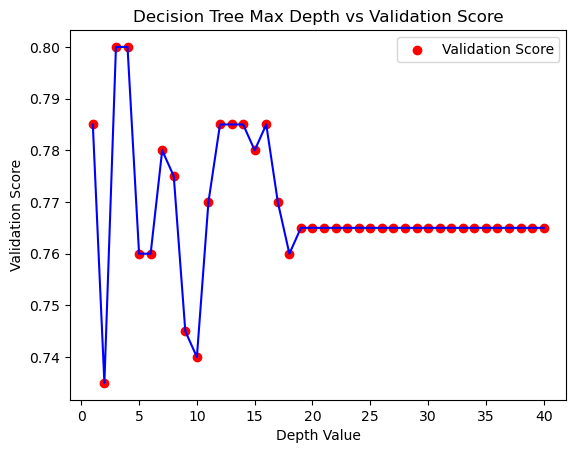

In [ ]:
plt.scatter(depths, val_accuracies, label='Validation Score', color='red', marker='o')

plt.plot(depths, val_accuracies, linestyle='-', color='blue')

plt.xlabel('Depth Value')
plt.ylabel('Validation Score')
plt.title('Decision Tree Max Depth vs Validation Score')

plt.legend()

plt.show()